In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr
import math as math
from scipy.optimize import curve_fit
import seaborn as sns

from netCDF4 import Dataset
import h5py

plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_15860\2217554283.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
dsm  = xr.open_dataset('eqcross_mv05iv06_r00_mti_2021 (1).nc')
dsi  = xr.open_dataset('eqcross_mv05iv06_r00_ivm_2021.nc')

dsi = dsi.load()

C:\Users\pkoll\anaconda3\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## With MIGHTI U and IVM drift_mer

In [3]:
dm0 = dsm[['u','v', 'q']].sel(dt=0).isel(alt=slice(2,-2)) # Only u, v variables, but also quality (q) variable for possible later filtering
di0 = dsi[['drift_mer','slt', 'time', 'dm_flag', 'rpa_flag']].sel(dt=0) # only use drift_mer variable (but also save other variables for context: local time, actual time, IVM data quality flags)

d = xr.merge((dm0, di0))
d = d.dropna(dim='num', how='any', subset=['u','drift_mer']) # Drop missing data

# Only keep later LTs and data where the ivm quality flag is good
d = d.where((d.slt > 11) & (d.slt < 16) & (d.q.mean(dim='alt') > 0.95) & (d.dm_flag == 0) & (d.rpa_flag == 0), drop=True)


In [4]:
d

<xarray.Dataset>
Dimensions:    (num: 1388, alt: 80)
Coordinates:
  * alt        (alt) float64 94.28 97.21 100.1 103.1 ... 293.1 295.4 297.7 300.0
    dt         float64 0.0
  * num        (num) int64 10 11 21 22 24 25 ... 7572 7576 7577 7582 7584 7586
Data variables:
    u          (num, alt) float64 -69.47 -34.12 15.9 ... -4.583 -10.62 -16.63
    v          (num, alt) float64 89.09 113.0 87.61 22.67 ... 78.85 86.1 93.33
    q          (num, alt) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    drift_mer  (num) float64 -1.099 -0.84 3.109 -5.834 ... 21.11 26.76 22.95
    slt        (num) float32 15.88 15.69 15.85 15.91 ... 15.85 15.99 15.92 15.89
    time       (num) datetime64[ns] 2021-01-01T14:41:48.128000 ... 2021-12-31...
    dm_flag    (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    rpa_flag   (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [11]:
# This will save all of the changes between the pairs.

delta_t_hr = [] 
delta_alt = [] 
delta_u = [] 
delta_drift_mer = []
delta_slt = [] 

#dsi0 = d.sel(dt=0) # Only need to consider central timestamp for each crossing (dt=0) - DONE ABOVE

for i in range(len(d.num)):
    # Status indicator
    if np.mod(i,10) == 0:
        print('%i / %i' % (i, len(d.num)))
    
    ds1 = d.isel(num=i)
    
    # Grab all other timestamps that are 24-24.15 hours in the future, collect them in dataset ds2, which is a subset of the full dataset
    delta_t = d.time - ds1.time 
    happens_soon_after = (delta_t > pd.to_timedelta('24h')) & (delta_t < pd.to_timedelta('24.15h'))
    ds2 = d.where(happens_soon_after, drop=True)
        
    # Record some parameters of interest.
    #delta_t_hr.extend(pd.to_timedelta(ds2.time - ds1.time).total_seconds()/3600.)
    #delta_alt.extend(ds2.alt - ds1.alt)
    delta_u.extend(ds2.u - ds1.u)
    delta_drift_mer.extend(ds2.drift_mer - ds1.drift_mer)
    #delta_slt.extend(np.mod(ds2.slt - ds1.slt + 12, 24) - 12) # Similar for local times (-12 to +12)
    
#delta_t_hr = np.array(delta_t_hr) #should all be between 24-24.15
#delta_alt = np.array(delta_alt) #should all be 0
delta_u = np.array(delta_u)
delta_drift_mer = np.array(delta_drift_mer)
#delta_slt = np.array(delta_slt) #not really needed for analysis

0 / 1388
10 / 1388
20 / 1388
30 / 1388
40 / 1388
50 / 1388
60 / 1388
70 / 1388
80 / 1388
90 / 1388
100 / 1388
110 / 1388
120 / 1388
130 / 1388
140 / 1388
150 / 1388
160 / 1388
170 / 1388
180 / 1388
190 / 1388
200 / 1388
210 / 1388
220 / 1388
230 / 1388
240 / 1388
250 / 1388
260 / 1388
270 / 1388
280 / 1388
290 / 1388
300 / 1388
310 / 1388
320 / 1388
330 / 1388
340 / 1388
350 / 1388
360 / 1388
370 / 1388
380 / 1388
390 / 1388
400 / 1388
410 / 1388
420 / 1388
430 / 1388
440 / 1388
450 / 1388
460 / 1388
470 / 1388
480 / 1388
490 / 1388
500 / 1388
510 / 1388
520 / 1388
530 / 1388
540 / 1388
550 / 1388
560 / 1388
570 / 1388
580 / 1388
590 / 1388
600 / 1388
610 / 1388
620 / 1388
630 / 1388
640 / 1388
650 / 1388
660 / 1388
670 / 1388
680 / 1388
690 / 1388
700 / 1388
710 / 1388
720 / 1388
730 / 1388
740 / 1388
750 / 1388
760 / 1388
770 / 1388
780 / 1388
790 / 1388
800 / 1388
810 / 1388
820 / 1388
830 / 1388
840 / 1388
850 / 1388
860 / 1388
870 / 1388
880 / 1388
890 / 1388
900 / 1388
910 / 1388

In [12]:
df_u = pd.DataFrame(delta_u)
df_drift_mer = pd.DataFrame(delta_drift_mer)

In [13]:
#Storing Data so I don't have to rerun everything
df_u.to_csv('delta_u.csv', index=False)  
df_drift_mer.to_csv('delta_drift_mer.csv', index=False)  

### PCA

In [77]:
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_u
y = df_drift_mer


#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_test)

X_reduced_train = sc.transform(X_train)
X_reduced_test = sc.transform(X_test)


pca = PCA(n_components = 8)
pca.fit(X_reduced_train)

X_train_pca = pca.transform(X_reduced_train)
X_test_pca = pca.transform(X_reduced_test)

model = LinearRegression(fit_intercept=True)
model.fit(X_train_pca, y_train)

y_pred_test_pca = model.predict(X_test_pca)
y_pred_train_pca = model.predict(X_train_pca)

from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_pred_train_pca)
r2_test = r2_score(y_test, y_pred_test_pca)

In [89]:
np.shape(X)

(1057, 80)

In [92]:
model.coef_[0]
np.shape(model.coef_[0])

(8,)

In [82]:
weight = pca.components_
np.shape(weight)

(8, 80)

In [84]:
# del_v = C.T dot del_u
del_v = X.dot(pca.components_.T)
np.shape(del_v)

(1057, 8)

In [96]:
# C.T dot A dot del_u
A = pca.components_.T.dot(model.coef_[0])
print(np.shape(A))

drift_vals = X.dot(A)
print(np.shape(drift_vals))


(80,)
(1057,)


In [86]:
#del_v = C*.T dot A dot del_u
A = (pca.components_.T).dot(model.coef_[0])
A

array([ 2.32446126e-02, -3.47704341e-01, -6.36563726e-01, -8.40350564e-01,
       -9.68171185e-01, -9.98165618e-01, -8.22422439e-01, -5.05891492e-01,
       -2.57304312e-01, -6.59781481e-02,  4.71959781e-02,  1.67281040e-01,
        2.07301045e-01,  3.19463727e-01,  2.60645656e-01,  2.47936144e-01,
        1.65215081e-01,  2.50520085e-01,  1.81368837e-01,  1.71425252e-01,
        1.39081837e-01,  1.20393801e-01,  7.22563185e-02,  9.15848052e-02,
        1.71181545e-02,  1.57277876e-01,  6.77513504e-02,  2.01487220e-02,
        3.06246268e-03, -1.25347129e-02, -2.88877905e-02, -4.38822165e-02,
       -4.31278386e-02, -3.44775398e-02, -2.45249648e-02, -1.41315177e-02,
       -1.03556773e-02, -9.50251764e-03, -8.33960982e-03, -6.96206317e-03,
       -1.47011856e-02, -2.75609514e-02, -3.95915299e-02, -4.98484519e-02,
       -4.70167744e-02, -3.55297244e-02, -2.23821096e-02, -8.76392166e-03,
       -7.42571926e-03, -1.37062576e-02, -1.94645990e-02, -2.42034009e-02,
       -2.34800778e-02, -

In [87]:
X.dot(A)

0       119.852093
1        91.975968
2      -270.842472
3        95.949241
4       127.861446
           ...    
1052   -184.068028
1053    -38.003826
1054    202.023425
1055    -27.329717
1056    471.716767
Length: 1057, dtype: float64

<IPython.core.display.Javascript object>


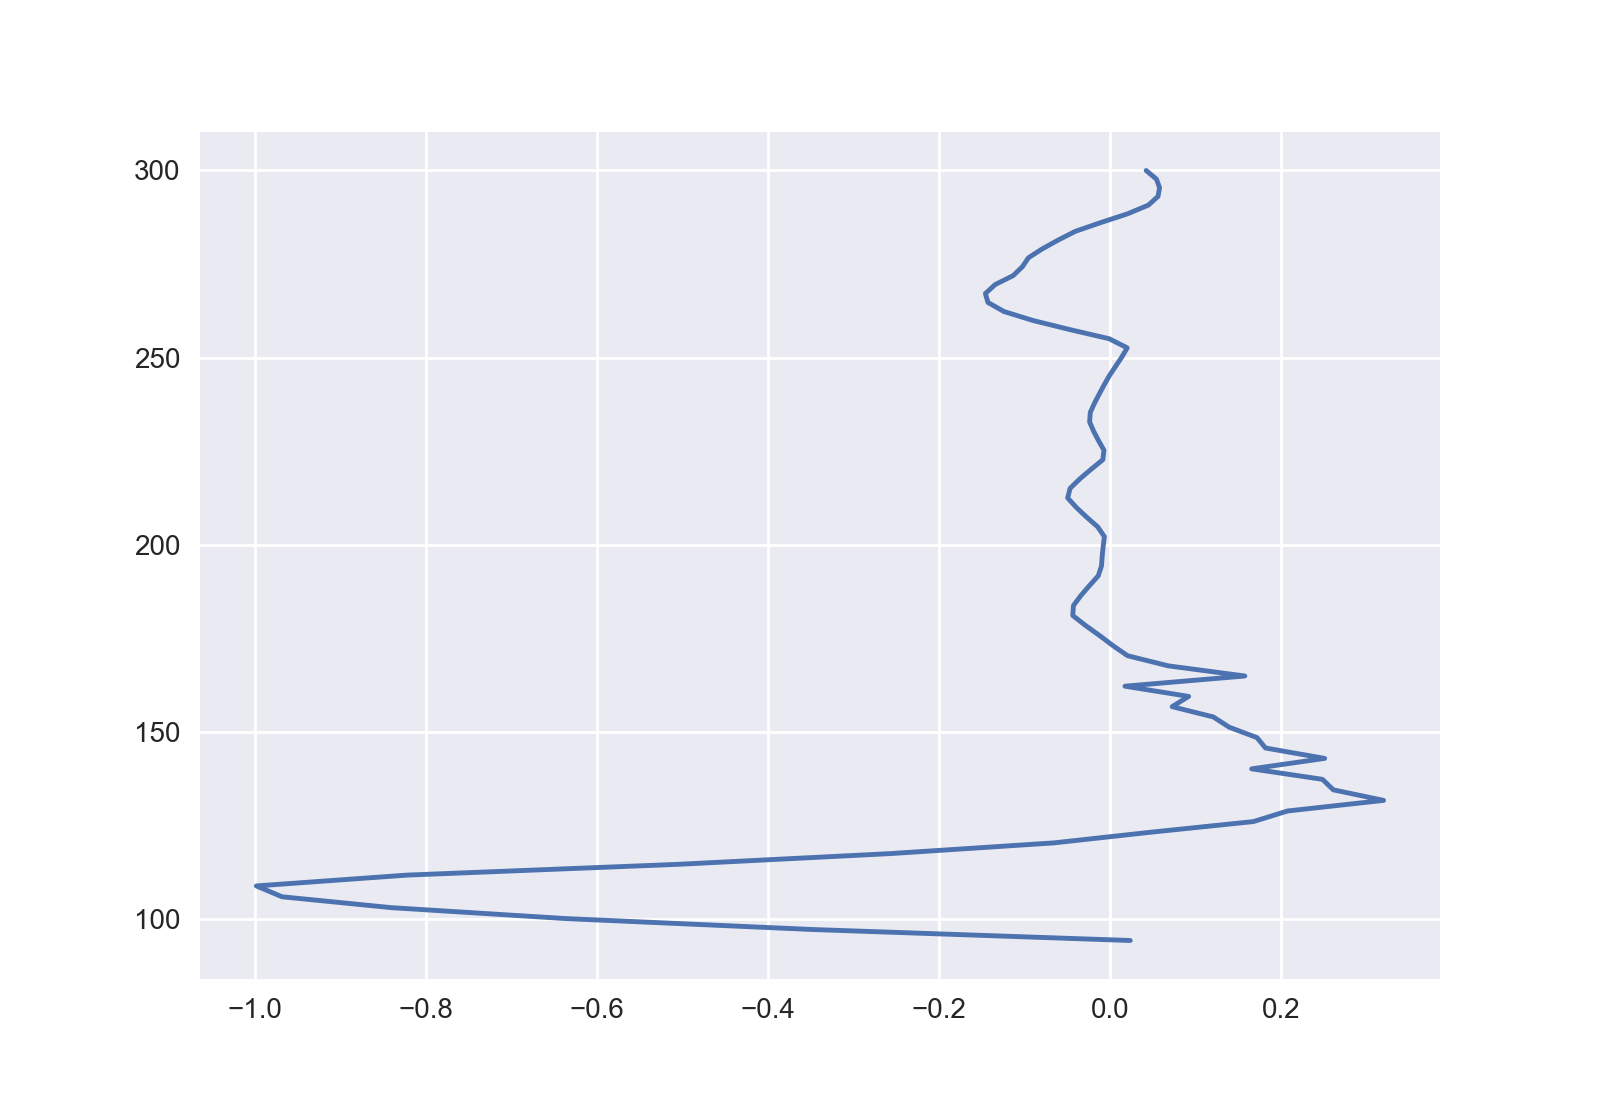

In [88]:
plt.figure()
plt.plot(A,d.alt)
#plt.plot(X.dot(A))
plt.show()